#### Imports

In [2514]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as ps

#### Preparing dataset for ML model

In [2515]:
linkedin = pd.read_csv('../data/linkedin_standarized.csv')
linkedin.sample(5)

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary
365,3770165247,Data Analyst,TEKGENCE INC,OH,Presencial,Contrato por obra,Sin experiencia,L,41280.0
245,3765320598,Data Engineer,SMX,VA,Presencial,Prácticas,Prácticas,L,NaN
324,3768901276,Data Engineer,Deseret First Credit Union,UT,Presencial,Contrato por obra,Sin experiencia,M,87360.0
439,3773347011,Data Scientist,Paycom,OK,Híbrido,Jornada completa,Intermedio,L,160000.0
222,3764175513,Data Engineer,"Cape Henry Associates, Acquired by JANUS Resea...",VA,Presencial,Jornada completa,Sin experiencia,L,105000.0


In [2516]:
linkedin.shape

(580, 9)

First we need to see which columns have null values.

In [2517]:
linkedin.isna().sum()

job_id               0
job_title            0
company_name         0
company_state        0
remote_ratio        17
employment_type      0
experience_level     3
company_size         6
salary              72
dtype: int64

The ones with salary range in null value, are going to be the predicted ones.

In [2518]:
to_predict = linkedin[linkedin['salary'].isnull()]
to_predict.shape

(72, 9)

In [2519]:
linkedin = linkedin[~linkedin['salary'].isnull()]
linkedin.shape

(508, 9)

Let's save this dataframe for sql queries.

In [2520]:
linkedin.to_csv('../data/linkedin_salaries_sql.csv', index=False)

Let's check again null values in order to delete those rows.

In [2521]:
linkedin.isna().sum()

job_id              0
job_title           0
company_name        0
company_state       0
remote_ratio        2
employment_type     0
experience_level    3
company_size        5
salary              0
dtype: int64

In [2522]:
linkedin = linkedin[linkedin[['remote_ratio']].notna().any(axis=1)]
linkedin = linkedin[linkedin[['experience_level']].notna().any(axis=1)]
linkedin = linkedin[linkedin[['company_size']].notna().any(axis=1)]
linkedin.shape

(499, 9)

##### Function to clean both datasets

In [2523]:
def prepare_dataset(dframe):
    df = dframe.copy()
    # df = df.drop(columns=['company_name', 'company_state'])
    df = df[df[['remote_ratio']].notna().any(axis=1)]
    df = df[df[['experience_level']].notna().any(axis=1)]
    df = df[df[['company_size']].notna().any(axis=1)]
    return df

In [2524]:
prepared_to_predict = prepare_dataset(to_predict)
prepared_to_predict.shape

(56, 9)

    Column 'job_title'

Classificating the job_title category with numbers.

In [2525]:
linkedin.groupby('job_title')['salary'].mean().reset_index().sort_values(by='salary', ascending=False)

,job_title,salary
7,Deep Learning Engineer,195115.090909
8,Machine Learning Engineer,176279.583333
9,Research Engineer,176125.000000
1,BI Analyst,155742.333333
6,Data Scientist,139677.333333
5,Data Engineer,131093.882353
4,Data Analyst,112255.272727
0,AI Engineer,96454.166667
3,Business Analyst,96250.000000
2,BI Engineer,75000.000000


    Column 'remote_ratio'

In [2526]:
linkedin['remote_ratio'].value_counts()

remote_ratio
En remoto     195
Híbrido       176
Presencial    128
Name: count, dtype: int64

    Column 'employment_type'

In [2527]:
linkedin['employment_type'].value_counts()

employment_type
Jornada completa     369
Contrato por obra    100
Prácticas             30
Name: count, dtype: int64

    Column 'experience_level'

In [2528]:
linkedin['experience_level'].value_counts()

experience_level
Intermedio                 254
Sin experiencia            133
Algo de responsabilidad     48
Prácticas                   45
Director                    17
Ejecutivo                    2
Name: count, dtype: int64

    Column 'company_size'

In [2529]:
linkedin['company_size'].value_counts()

company_size
L    314
M    166
S     19
Name: count, dtype: int64

#### Cleaning function

In [2530]:
def categorizing_dataset(dframe):
    # ------ Cleaning: group
    df = dframe.copy()

    # 1. job_title
    job_categories = {
        'Deep Learning Engineer': 10,
        'Machine Learning Engineer': 9,
        'Research Engineer': 8,
        'BI Analyst': 7,
        'Data Scientist': 6,
        'Data Engineer': 5,
        'Data Analyst': 4,
        'Business Analyst': 3,
        'AI Engineer': 2,
        'BI Engineer': 1
    }
    df["job_title"] = df.job_title.replace(job_categories)

    # 2. remote_ratio
    remote_categories = {
        'En remoto': 100,
        'Híbrido': 50,
        'Presencial': 0
    }
    df["remote_ratio"] = df.remote_ratio.replace(remote_categories)

    # 3. employment_type
    oneonehotencoder = ps.OneHotEncoder()
    df[['Jornada completa', 'Contrato por obra', 'Prácticas']] = oneonehotencoder.fit_transform(df["employment_type"].values.reshape(-1, 1)).toarray()

    # 4. experience_level
    experience_categories = {
        'Director': 3,
        'Ejecutivo': 3,
        'Algo de responsabilidad': 2,
        'Intermedio': 2,
        'Sin experiencia': 1,
        'Prácticas': 0
    }
    df["experience_level"] = df.experience_level.replace(experience_categories)

    # 5. company_size
    df[['L', 'M', 'S']] = oneonehotencoder.fit_transform(df["company_size"].values.reshape(-1, 1)).toarray()

    return df

In [2531]:
prepared_linkedin = categorizing_dataset(linkedin)
prepared_linkedin.sample(5)

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary,Jornada completa,Contrato por obra,Prácticas,L,M,S
417,3772699484,6,Crossover,WA,100,Jornada completa,2,L,57600.0,0.0,1.0,0.0,1.0,0.0,0.0
292,3767189280,5,"GEI Consultants, Inc.",NY,50,Jornada completa,2,L,62500.0,0.0,1.0,0.0,1.0,0.0,0.0
370,3770183600,5,Maxonic,CA,50,Contrato por obra,1,L,34560.0,1.0,0.0,0.0,1.0,0.0,0.0
58,3739504870,6,Alphatec Spine,CA,0,Jornada completa,1,L,203556.0,0.0,1.0,0.0,1.0,0.0,0.0
253,3765447906,9,EVONA,CA,100,Contrato por obra,2,M,72500.0,1.0,0.0,0.0,0.0,1.0,0.0


In [2532]:
prepared_to_predict = categorizing_dataset(prepared_to_predict)
prepared_to_predict.sample()

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary,Jornada completa,Contrato por obra,Prácticas,L,M,S
311,3768300248,4,Accroid Inc,VA,0,Prácticas,0,M,NaN,0.0,0.0,1.0,0.0,1.0,0.0


In [2533]:
prepared_to_predict.isna().sum()

job_id                0
job_title             0
company_name          0
company_state         0
remote_ratio          0
employment_type       0
experience_level      0
company_size          0
salary               56
Jornada completa      0
Contrato por obra     0
Prácticas             0
L                     0
M                     0
S                     0
dtype: int64

In [2534]:
# Viz mantra
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

from sklearn import metrics

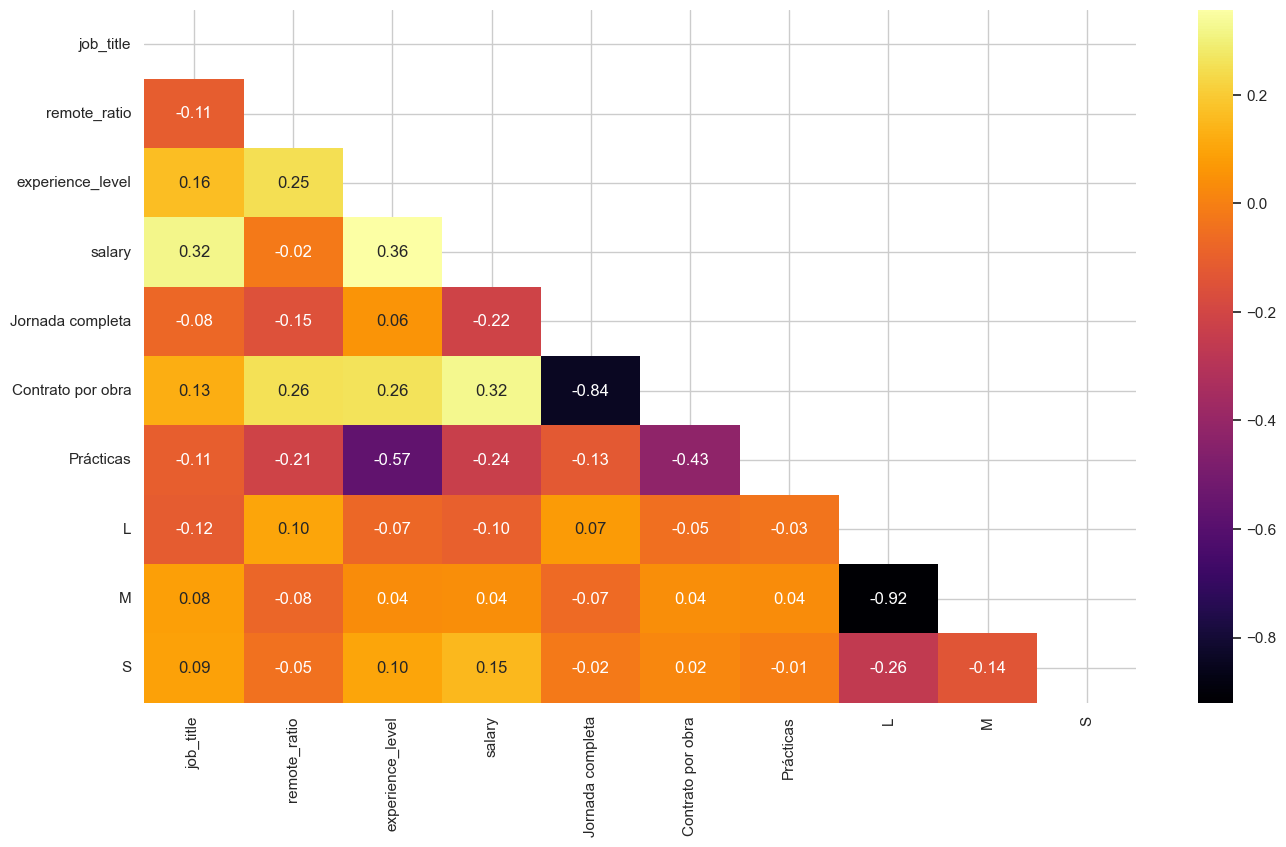

In [2535]:
corr = prepared_linkedin.select_dtypes(exclude=['object']).drop(columns=['job_id']).corr()
sns.heatmap(corr, annot=True, cmap='inferno', fmt='.2f', mask=np.triu(corr));

#### Models

In [2536]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [2537]:
# X = prepared_linkedin.select_dtypes(exclude='object').drop(columns=['salary', 'min_salary', 'max_salary'])
X = prepared_linkedin.select_dtypes(exclude='object').drop(columns=['salary'])
y = prepared_linkedin['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [2538]:
y_train

249    148800.0
74      79586.0
362     41280.0
484     72556.0
91     106000.0
         ...   
25     209000.0
308    175000.0
310    175000.0
81     107500.0
426     57600.0
Name: salary, Length: 399, dtype: float64

    LinearRegression

In [2539]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [2540]:
y_pred = regressor.predict(X_test)

In [2541]:
metrics.r2_score(y_test, y_pred)

0.16215618838684487

    DecisionTreeRegressor

In [2542]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [2543]:
y_pred = regressor.predict(X_test)

In [2544]:
metrics.r2_score(y_test, y_pred)

-0.6039823229826109

    KNeighborsRegressor

In [2545]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [2546]:
y_pred = regressor.predict(X_test)

In [2547]:
metrics.r2_score(y_test, y_pred)

0.5206075357492368

    GradientBoostingRegressor

In [2548]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [2549]:
y_pred = regressor.predict(X_test)

In [2550]:
metrics.r2_score(y_test, y_pred)

0.7046337116799974

    RandomForestRegressor

In [2551]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [2552]:
y_pred = regressor.predict(X_test)

In [2553]:
r2 = metrics.r2_score(y_test, y_pred)
r2

0.664004034106267

    SVR

In [2566]:
from sklearn.svm import SVR

regressor = SVR(kernel='linear')
regressor.fit(X_train, y_train)

In [2555]:
y_pred = regressor.predict(X_test)

In [2556]:
metrics.r2_score(y_test, y_pred)

-0.05773670250507079

    Code to save the model

In [ ]:
import pickle

# model_file = f'../models/RandomForestRegressor_r2_{r2}.pkl'
# with open(model_file, 'wb') as f:
#     pickle.dump(regressor, f)

In [2558]:
model_file = '../models/RandomForestRegressor_r2_0.664004034106267.pkl'
with open(model_file, 'rb') as f:
    model = pickle.load(f)

pred = model.predict(X_test)
# pred = model.predict(X_test.drop(columns=['min_salary', 'max_salary']))

r2_pred = metrics.r2_score(y_test, pred)
r2_pred

0.9486584602145752

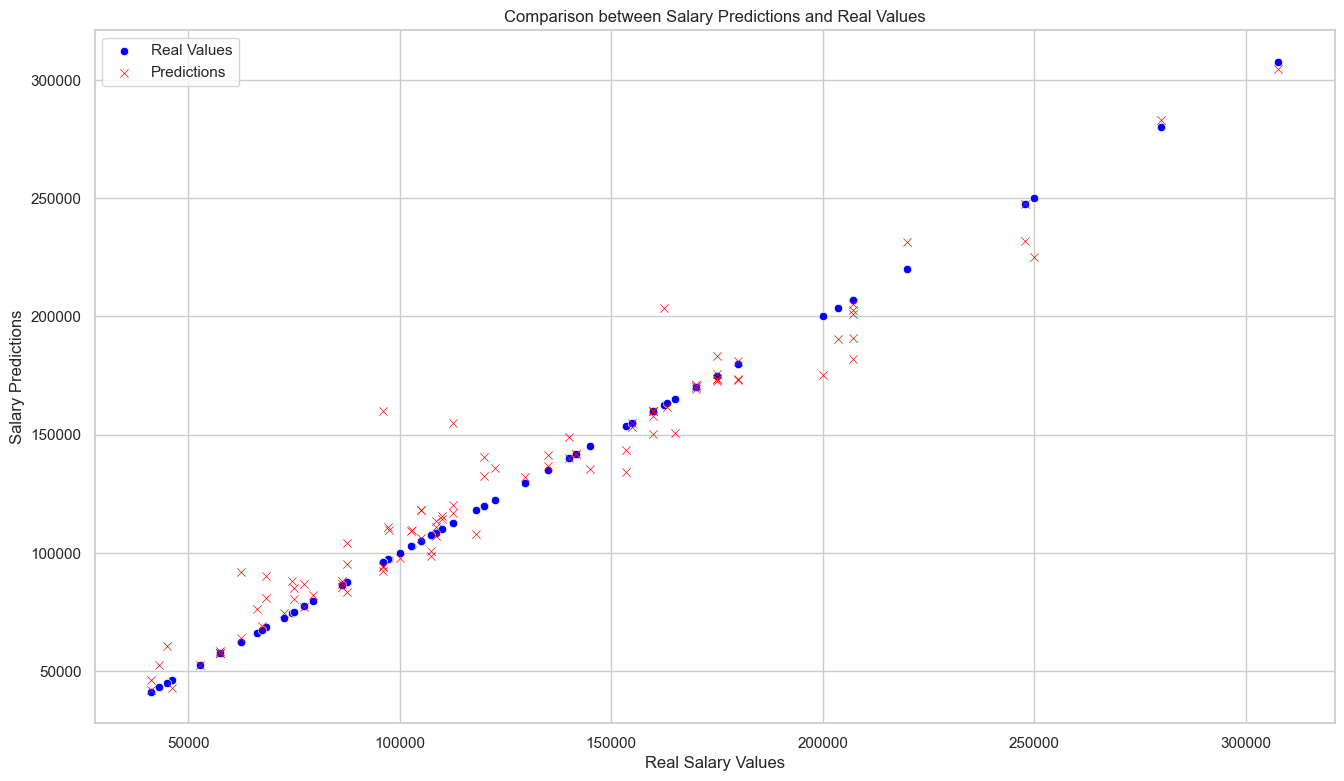

In [2559]:
sns.scatterplot(x=y_test, y=y_test, color='blue', label='Real Values', marker='o')
sns.scatterplot(x=y_test, y=pred, color='red', label='Predictions', marker='x')

plt.xlabel('Real Salary Values')
plt.ylabel('Salary Predictions')
plt.title('Comparison between Salary Predictions and Real Values')
plt.legend()
# plt.savefig('../figures/RFRmodel_accuracy_v2.jpg')
plt.show()

#### TESTS with X_test

In [2560]:
X_test_copy = X_test.copy()
X_test_copy['pred_salary'] = y_pred
X_test_copy['salary'] = y_test
X_test_copy.sample(5)

,job_id,job_title,remote_ratio,experience_level,Jornada completa,Contrato por obra,Prácticas,L,M,S,pred_salary,salary
297,3767516429,6,0,0,0.0,0.0,1.0,1.0,0.0,0.0,141799.900902,96000.0
260,3766041063,5,50,2,0.0,1.0,0.0,1.0,0.0,0.0,141799.901111,160000.0
448,3773873837,7,100,2,0.0,1.0,0.0,1.0,0.0,0.0,141799.900003,97227.0
194,3762359632,6,50,2,0.0,1.0,0.0,1.0,0.0,0.0,141799.901631,180000.0
331,3769052423,6,100,2,0.0,1.0,0.0,0.0,0.0,1.0,141799.900685,110000.0


    Saving X_test and prediction to see accuracy in tableau

In [2561]:
X_test_copy.to_csv('../data/tableau_csv/X_test.csv')

#### Prediction for those with null salary

In [2562]:
prediction = regressor.predict(prepared_to_predict.select_dtypes(exclude=['object']).drop(columns=['salary']))

In [2563]:
to_predict.sample()

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary
97,3752872433,Data Scientist,Copart,TX,Híbrido,Prácticas,Prácticas,L,NaN


In [2564]:
prepared_to_predict['salary'] = prediction # Adding the predicted price
prepared_to_predict.sample(5)

,job_id,job_title,company_name,company_state,remote_ratio,employment_type,experience_level,company_size,salary,Jornada completa,Contrato por obra,Prácticas,L,M,S
99,3753408170,10,NVIDIA,CA,50,Prácticas,0,L,141799.902896,0.0,0.0,1.0,1.0,0.0,0.0
531,3776278514,9,"UES, An Eqlipse Company",OH,0,Prácticas,0,L,141799.899663,0.0,0.0,1.0,1.0,0.0,0.0
571,3776948509,6,HustleWing - Side hustles for professionals,Estados Unidos,100,Media jornada,2,S,141799.899569,0.0,1.0,0.0,0.0,0.0,1.0
444,3773408834,4,Ecclesiastes Inc,DE,0,Media jornada,1,M,141799.900069,0.0,1.0,0.0,0.0,1.0,0.0
272,3766682212,5,DeRisk Technologies,WA,50,Media jornada,0,L,141799.901020,0.0,1.0,0.0,1.0,0.0,0.0


In [2565]:
prepared_to_predict.to_csv('../data/linkedin_predicted_sql.csv', index=False)